In [1]:
import pandas as pd
from glob import glob
from evaluate.report import Report, PrecisionReport, RecallReport
from collections import defaultdict, namedtuple
import re
import intervaltree
import seaborn as sns
sns.set()
import json

def dump_dict(dictionary, filename):
    json_str = json.dumps(dictionary)
    with open(f"{filename}.json","w") as fout:
        fout.write(json_str)

In [2]:
##################################################################################################################
# configs
reports_tsv_glob_path = "/home/leandro/git/pandora_paper_roc/external_scripts/pandora_FN_exploration/data/hps/nobackup/iqbal/leandro/pdrv/out_20_way/pandora_paper_roc/analysis_output_pandora_paper_tag1/recall/reports/*/100x/pandora_nanopore_withdenovo/coverage_filter_0/strand_bias_filter_0.0/gaps_filter_1.0/gt_conf_percentile_0/*.tsv"
samples = ['063_STEC', 'Escherichia_coli_MINF_1D', 'Escherichia_coli_MINF_9A', 'Escherichia_coli_MSB1_4E', 'Escherichia_coli_MSB1_7A', 'Escherichia_coli_MSB1_8G', 'H131800734', 'CFT073', 'Escherichia_coli_MINF_7C', 'Escherichia_coli_MSB1_1A', 'Escherichia_coli_MSB1_4I', 'Escherichia_coli_MSB1_7C', 'Escherichia_coli_MSB1_9D', 'ST38', 'Escherichia_coli_MINF_1A', 'Escherichia_coli_MINF_8D', 'Escherichia_coli_MSB1_3B', 'Escherichia_coli_MSB1_6C', 'Escherichia_coli_MSB1_8B', 'Escherichia_coli_MSB2_1A']
samples = ['063_STEC', 'CFT073']  # TODO: remove
gene_localisation_dir="/home/leandro/git/pandora_paper_roc/external_scripts/pandora_FN_exploration/data/hps/nobackup/iqbal/leandro/pdrv/out_20_way/pandora_gene_distance/gene_distance_pandora_paper_tag1/genes_from_truth_or_ref/pandora_nanopore_100x_withdenovo"
##################################################################################################################

In [3]:
reports_filepaths = glob(reports_tsv_glob_path)
recall_report = RecallReport.from_files(reports_filepaths,
                                        concatenate_dfs_one_by_one_keeping_only_best_mappings=True)

In [4]:
variation_found_nbofsamples = recall_report.get_proportion_of_allele_seqs_found_for_each_variant_with_nb_of_samples(
    binary=True
)
variation_found_nbofsamples.rename(columns={"proportion_of_allele_seqs_found_binary": "FOUND"}, inplace=True)
variation_found_nbofsamples.reset_index(inplace=True)
variation_found_nbofsamples

,PANGENOME_VARIATION_ID,FOUND,NB_OF_SAMPLES
0,0,0,2
1,1,1,4
2,2,1,2
3,3,1,20
4,4,1,19
...,...,...,...
449100,505130,0,14
449101,505131,0,14
449102,505132,0,14
449103,505133,0,14


In [5]:
Coordinate = namedtuple('Coordinate', ['sample', 'chrom', 'pos'])
pv_allele_seq_id_to_coordinates = defaultdict(set)
for report_filepath in reports_filepaths:
    report_df = pd.read_csv(report_filepath, sep="\t")
    for query_probe_header in report_df.query_probe_header:
        chrom, sample, pos, pv_id, allele_seq_id = re.findall("CHROM=(.+?);SAMPLE=(.+?);POS=(.+?);.*;PANGENOME_VARIATION_ID=(.+?);.*;ALLELE_SEQUENCE_ID=(.+?);", query_probe_header)[0]
        pos, pv_id, allele_seq_id = int(pos), int(pv_id), int(allele_seq_id)
        pv_allele_seq_id_to_coordinates[(pv_id, allele_seq_id)].add(Coordinate(sample, chrom, pos))
pv_allele_seq_id_to_coordinates

defaultdict(set,
            {(37324, 1): {Coordinate(sample='063_STEC', chrom='0', pos=79)},
             (37325, 0): {Coordinate(sample='063_STEC', chrom='0', pos=112)},
             (37326, 1): {Coordinate(sample='063_STEC', chrom='0', pos=121)},
             (37327, 0): {Coordinate(sample='063_STEC', chrom='0', pos=139)},
             (37330, 1): {Coordinate(sample='063_STEC', chrom='0', pos=193)},
             (37333, 1): {Coordinate(sample='063_STEC', chrom='0', pos=370)},
             (118326, 1): {Coordinate(sample='063_STEC', chrom='0', pos=538)},
             (118327, 1): {Coordinate(sample='063_STEC', chrom='0', pos=601)},
             (118328, 0): {Coordinate(sample='063_STEC', chrom='0', pos=879)},
             (118329, 0): {Coordinate(sample='063_STEC', chrom='0', pos=913)},
             (118330, 0): {Coordinate(sample='063_STEC', chrom='0', pos=1039)},
             (118332, 1): {Coordinate(sample='063_STEC', chrom='0', pos=1273)},
             (37336, 1): {Coordinate(sam

In [6]:
sample_to_chrom_to_intervaltree = defaultdict(lambda: defaultdict(lambda: intervaltree.IntervalTree()))

for sample in samples:
    with open(gene_localisation_dir+f"/{sample}.csv") as gene_localisation_fh:
        for line in gene_localisation_fh:
            status,gene_name,ref_or_truth_id,contig,start,stop,sequence = line.split(",")
            if status=="Mapped":
                sample_to_chrom_to_intervaltree[ref_or_truth_id][contig][int(start) : int(stop)] = gene_name
sample_to_chrom_to_intervaltree

defaultdict(<function __main__.<lambda>()>,
            {'063_STEC': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'0': IntervalTree([Interval(3, 1404, 'GC00000491_1'), Interval(1700, 1898, 'GC00003082'), Interval(2010, 2148, 'GC00001920'), Interval(2200, 2524, 'GC00002322'), Interval(2490, 2745, 'GC00002627'), Interval(2561, 2750, 'Cluster_4592'), Interval(2750, 4394, 'GC00001921'), Interval(4397, 4502, 'Cluster_9156'), Interval(4502, 5864, 'GC00001724'), Interval(5867, 6172, 'Cluster_2653'), Interval(6108, 6180, 'GC00002323'), Interval(6403, 7816, 'GC00002763'), Interval(7633, 7909, 'Cluster_3176'), Interval(7819, 7954, 'Cluster_7792'), Interval(7909, 9154, 'GC00000131_2'), Interval(9157, 9289, 'Cluster_3743'), Interval(9289, 10462, 'GC00001922'), Interval(10439, 11396, 'GC00001089_2'), Interval(11399, 11555, 'Cluster_6906'), Interval(11555, 12302, 'GC00002506'), Interval(12185, 12326, 'Cluster_7528'), Interval(12326, 12890, 'GC00002324'), In

In [7]:
def find_genes(coordinate):
    genes = []  # a list because a coordinate might have several genes going through it
    for gene in sample_to_chrom_to_intervaltree[coordinate.sample][coordinate.chrom][coordinate.pos]:
        genes.append(gene.data)
    return genes

pv_allele_seq_id_to_genes = defaultdict(list)
for pv_allele_seq_id, coordinates in pv_allele_seq_id_to_coordinates.items():
    for coordinate in coordinates:
        pv_allele_seq_id_to_genes[pv_allele_seq_id].extend(find_genes(coordinate))
pv_allele_seq_id_to_genes

defaultdict(list,
            {(37324, 1): ['GC00000491_1'],
             (37325, 0): ['GC00000491_1'],
             (37326, 1): ['GC00000491_1'],
             (37327, 0): ['GC00000491_1'],
             (37330, 1): ['GC00000491_1'],
             (37333, 1): ['GC00000491_1'],
             (118326, 1): ['GC00000491_1'],
             (118327, 1): ['GC00000491_1'],
             (118328, 0): ['GC00000491_1'],
             (118329, 0): ['GC00000491_1'],
             (118330, 0): ['GC00000491_1'],
             (118332, 1): ['GC00000491_1'],
             (37336, 1): [],
             (37337, 0): [],
             (37338, 0): [],
             (158057, 1): [],
             (118335, 0): ['GC00003082'],
             (118336, 1): ['GC00003082'],
             (118337, 0): ['GC00003082'],
             (37339, 0): ['GC00001921'],
             (118338, 0): ['GC00001921'],
             (118339, 0): ['GC00001921'],
             (37342, 1): ['GC00001921'],
             (4, 0): ['GC00001921'],
             (

In [8]:
pv_allele_seq_id_to_genes_found_by_pandora = {}
for pv_allele_seq_id, gene_list in pv_allele_seq_id_to_genes.items():
    pv_allele_seq_id_to_genes_found_by_pandora[pv_allele_seq_id] = set(gene_list)
pv_allele_seq_id_to_genes_found_by_pandora


pv_ids = set()
for pv_allele_seq_id in pv_allele_seq_id_to_genes.keys():
    pv_ids.add(pv_allele_seq_id[0])

    
pv_id_to_genes_found_by_pandora = {}
for pv_id in pv_ids:
    pv_id_to_genes_found_by_pandora[pv_id] = \
        list(pv_allele_seq_id_to_genes_found_by_pandora.get((pv_id, 0), set()).union( 
        pv_allele_seq_id_to_genes_found_by_pandora.get((pv_id, 1), set())))
pv_id_to_genes_found_by_pandora

pv_id_to_nb_of_genes_found_by_pandora = {}
for pv_id, genes in pv_id_to_genes_found_by_pandora.items():
    pv_id_to_nb_of_genes_found_by_pandora[pv_id] = len(genes)
pv_id_to_nb_of_genes_found_by_pandora
    
pv_id_to_nb_of_genes_found_by_pandora_df = pd.DataFrame(data=pv_id_to_nb_of_genes_found_by_pandora.items(),
                                                 columns=["PANGENOME_VARIATION_ID", "NB_OF_GENES"])
pv_id_to_nb_of_genes_found_by_pandora_df["FOUND_IN_VCF_REF"] = (pv_id_to_nb_of_genes_found_by_pandora_df["NB_OF_GENES"] > 0).astype(int)
pv_id_to_nb_of_genes_found_by_pandora_df

,PANGENOME_VARIATION_ID,NB_OF_GENES,FOUND_IN_VCF_REF
0,0,1,1
1,1,2,1
2,2,3,1
3,3,2,1
4,4,2,1
...,...,...,...
449100,505130,1,1
449101,505131,1,1
449102,505132,1,1
449103,505133,1,1


In [9]:
dump_dict(pv_id_to_genes_found_by_pandora, "pv_id_to_genes_found_by_pandora")

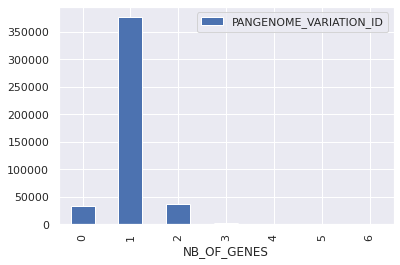

In [10]:
pv_ids_to_nb_of_genes_summary = pv_id_to_nb_of_genes_found_by_pandora_df[["PANGENOME_VARIATION_ID", "NB_OF_GENES"]].groupby("NB_OF_GENES").count()
plot = pv_ids_to_nb_of_genes_summary.plot(kind="bar")
fig = plot.get_figure()
fig.savefig("pandora_nb_of_genes_for_panvars.png")

In [11]:
variation_found_nbofsamples = variation_found_nbofsamples.merge(pv_id_to_nb_of_genes_found_by_pandora_df)
variation_found_nbofsamples["NOT_FOUND_BY_PANDORA_BUT_IN_VCF_REF"] = ((variation_found_nbofsamples["FOUND"]==0) & (variation_found_nbofsamples["FOUND_IN_VCF_REF"]==1)).astype(int)
variation_found_nbofsamples["NOT_FOUND_BY_PANDORA_AND_NOT_IN_VCF_REF"] = ((variation_found_nbofsamples["FOUND"]==0) & (variation_found_nbofsamples["FOUND_IN_VCF_REF"]==0)).astype(int)
variation_found_nbofsamples

,PANGENOME_VARIATION_ID,FOUND,NB_OF_SAMPLES,NB_OF_GENES,FOUND_IN_VCF_REF,NOT_FOUND_BY_PANDORA_BUT_IN_VCF_REF,NOT_FOUND_BY_PANDORA_AND_NOT_IN_VCF_REF
0,0,0,2,1,1,1,0
1,1,1,4,2,1,0,0
2,2,1,2,3,1,0,0
3,3,1,20,2,1,0,0
4,4,1,19,2,1,0,0
...,...,...,...,...,...,...,...
449100,505130,0,14,1,1,1,0
449101,505131,0,14,1,1,1,0
449102,505132,0,14,1,1,1,0
449103,505133,0,14,1,1,1,0


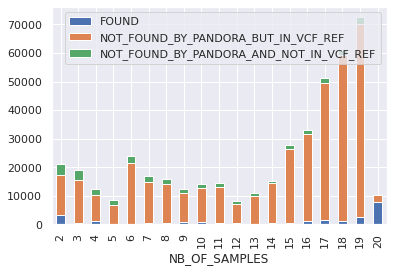

In [12]:
df = variation_found_nbofsamples[["NB_OF_SAMPLES", "FOUND", "NOT_FOUND_BY_PANDORA_BUT_IN_VCF_REF", "NOT_FOUND_BY_PANDORA_AND_NOT_IN_VCF_REF"]].groupby("NB_OF_SAMPLES").sum()
plot = df.plot(kind='bar', stacked=True)
fig = plot.get_figure()
fig.savefig("pandora_FN.png")